## Data Generator 
Created: February 18, 2020

This series of notebooks generate synthetic data for different components of the food supply chain. It models activities like restaurant orders using normal distributions with parameters number of events $n$, mean $\mu$, and standard deviation $\sigma$.  After the distribution or distributions are is created, a function samples the distribution and generates $n$ events for a telemetry event. The events are written to a text file and exported locally. There is an option to skip the event information and write the files to a CSV instead. 

This notebook specifically allows a user to specify any number of parameters (3 for normal distribution) for any number of distributions using a textfile. This generates events that are saved and plots a histogram of those events. 

The outputs of the events follows the data model described in this document: https://zumepizza.atlassian.net/wiki/spaces/TERA/pages/615318459/Data+Model

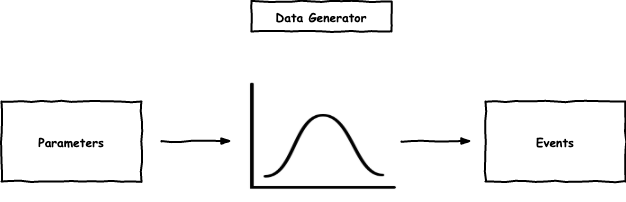

In [1]:
from IPython.display import Image
Image(filename="/Users/newtonkwan/Documents/zume/data-generator/data_generator_pipeline.png")

### Version 1 (2/6/20)
- Shows how to create a normal distribution
- Outputs three text files, each with one of example of the following: telemetry event, enriched event, and enriched session. 

### Version 2 (2/10/20)
- Same as version 1 including the following
- Write three functions that allow a user to specify the number of events to simulate for each of the three kinds of events. The outputs are three text files, each with n number of events of the following kind: telemetry event, enriched event, and enriched session. 

### Version 3 (2/10/20)
- Same as version 2 including the following
- Written a function that generates synthetic data for tomato harvests by month that follows a normal distribution whose parameters can be user specified. 
- The event enrichment events generator can generate 100,000 events every 5 seconds and write those events in about 5 seconds for a total of 10 seconds per 100,000 events. 

### Version 4 (2/12/20)
- Same as version 3 including the following
- Written a function that generates synthetic data for Tito's Tacos that has two normal distributions to describe lunch and dinner orders using 6 user specfied parameters (number of lunch orders, number of dinner orders, lunch mean, dinner mean, lunch standard deviation, and dinner standard deviation) to generate data. 
- Added details Part C to telemetry events for orders because I did not consider order details to be event enrichment.
- Plotted a denormlaized normal distribution (amplitude * pdf) rather than normalizing the histogram and fitting it to a pdf because it is more intuitive to view orders of the y-axis than a probability density for number of orders 

### Version 5 (2/12/20)
- Same as version 4 including the following
- Wrote a function that can take in an arbitrary number of sets of parameters (say lunch and dinner or breakfast, lunch, dinner, and dessert).
- Instead of hardcoding in the parameters, a user can specify the parameters in a textfile 
- The readability of the code has been greatly improved by abstracting out the event generating part into its own function, which allows for n number of sets of parameters. 

### Version 6 (2/13/20)
- Same as version 5 including the following
- Explicitly wrote assumptions for the data being generated, including each event being a unique consumer, each event being a unique session, and each event being only one business customer. 
- Added a simple diagram explaining the data generator. 

### Version 7 (2/18/20)
- Same as version 6 including the following
- Changed the timestamps to be specified by a date range, not just the current time. 

### Version 7.1 (2/19/20)
- Same as version 6 including the following
- The ability to export the data generated as a csv rather than in the already predefined event schema. 

In [74]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
import json
from datetime import datetime,timezone,timedelta
from dateutil import tz
import uuid
import random
import time
import os
%config InlineBackend.figure_format = 'retina'

Parameters for restaurant 1 
number of orders, mu, sigma
200, 12.5, 1
250, 18.5, 1.2

Parameters for restaurant 2 
number of orders, mu, sigma
180, 12.0, 1.0
275, 18.5, 1.1

Parameters for restaurant 3
number of orders, mu, sigma
210, 12.2, 0.9
290, 19.0, 1.0



In [75]:
def write_to_file(events, filename):
    '''
    Converts a list of dictionaries into json events saved as a text file as filename
    Input: Events is a list of events dictionaries and filename is a string
    Output: Print number of events written and filename 
    '''
    n = len(events)
    with open(filename, 'w') as file_json: 
        json.dump(events, file_json)
    
    print("Successfully created the file", filename, "with", n, "events")
    return 

In [79]:
def sample_distributions(num_of_orders, mu, sigma):
    '''
    This function takes three parameters, creates a distribution, and samples that 
    distribution to create a list of events. 
    Ex: [100, 6, 1]
    The function would create a normal distribution with n = 100, mean = 6, and 
    standard deviation = 1, sample the distribution 100 times, creating 100 events 
    in the format of the data model. It will return a list of these events 
    
    Input: number of orders, the mean mu, and the standard deviation sigma 
    Output: returns n events in a list 
    '''
    events = [] 
    samples = []
    
    # assumptions
    # customer is the same for all events 
    customer = "Titos Tacos"       
    
    # the hub is always the same 
    hub_id = str(uuid.uuid1())   
    
    base = datetime(2019, 12, 31)    # last day to generate data 
    numdays = 1                      # number of days to generate data for 
    dateList = []                    # list of dates to generate data for 
    for x in range (0, numdays):
        dateList.append(base - timedelta(days = x))
    
    # the session is always unique per event  
    
    for curr_date in dateList:
        for i in range(num_of_orders):
            event_dict = {} 
            
            # setting up variables
            from_zone = tz.tzutc()
            to_zone = tz.tzlocal()
            utc = datetime.utcnow() 
            utc = utc.replace(tzinfo=from_zone)
            #local = utc.astimezone(to_zone)
            
            # part A telemetry event
            correlation_id = str(uuid.uuid1())   # will always be unique for each event 
            customer = "Titos Tacos"             # business customer the row was generated for
            type_of_data = "event"              
            version = "1.0.0"
            source = "telemetry"
            UTCtimestamp = str(utc)              # UTC of time the event was generated 
    
            # part B telemetry details
            event_type = "customer_order"
            customer_id = str(uuid.uuid1())      # ID of a specific customer 
            session_id = str(uuid.uuid1())
            hub_id = hub_id                      # unique to the restaurant location
            hub_location = None                  # None if it's stationary
            menu_version =  "1.0.0"
            experiments = None    
            

            hour_decimal = round(np.random.normal(mu, sigma, 1)[0], 2)
            hour_floor = int(np.floor(hour_decimal))
            minute_decimal = (hour_decimal - hour_floor) * 60 
            minute_floor = int(np.floor(minute_decimal))
            second_decimal = (minute_decimal - minute_floor) * 60
            second_floor = int(np.floor(second_decimal))
            
            curr_date = curr_date.replace(hour=hour_floor, minute=minute_floor, second=second_floor, tzinfo = tz.tzlocal())
            localtime = str(curr_date)                                      # local time of the event at the restaurant 
            UTCeventtime = str(curr_date.astimezone(tz.tzutc()))            #  UTC of the event at the restaurant 
    
            # part C telemetry details 
            order_snapshot = []
            number_of_skus = random.randint(1,2) # generate 1 or 2 
            if number_of_skus == 1: 
                total = 6.0 
            else: 
                total = 15.50 
            for sku_num in range(number_of_skus):
                if sku_num == 0: 
                    subtotal_sample = 6.0 
                else: 
                    subtotal_sample = 9.50
                d = {"sku": sku_num+1, 
                     "amount": 1,
                     "subtotal": subtotal_sample,
                     "total": total
                     #,"hour of the day": hour_decimal
                     }
                order_snapshot.append(d)
                
            samples.append(hour_decimal)
        
            # part C telemetry details
            partC_event_details_dict = {"order_snapshot": order_snapshot
                                                  }
            
            # part B telemetry details
            partB_event_details_dict = {"event_type": event_type,           # Every event (part A type) has a event type in part B
                                        "customer_id": customer_id,         # The ID for a specific customer. This is null if a customer is not logged in or we cannot find it 
                                        "session_id": session_id,           # An ID that joins a set of events into a specific customer session. 
                                        "hub_id": hub_id,                   # The ID for the specific Hub (kiosk, etc.) that is being viewed
                                        "hub_location": hub_location,       # The location of the specific hub. For hub's in which the location does not every change, such as a fixed Kiosk, this field will be null as location can be obtained through a lookup
                                        "menu_version": menu_version,       # You can lookup details about this menu with this id.  
                                        "experiments": experiments,         # If a user is in an experiment, it would be represented here in the format experiment:treatment with pipe delimitation.  E.G. if the user was in treatment 2 of a ux experiment titled redbuttons, and treatment 12 of an experiment titled aggressivemarketing, the field would be "redbuttons:2|aggressivemarketing:12
                                        "localtime": localtime,             # The local time this event was generated
                                        "UTCtime": UTCeventtime,            # The utc time this event was generated
                                        "details": partC_event_details_dict
                                       }
            
            # part A 
            event_dict = {"correlation_id": correlation_id,    # The is the id associated with all telemetry events 
                          "customer": customer,
                          "type": type_of_data,                # The type of data. Typically "event", which is something generated off of a specific event
                          "version": version,                  # The version of this data
                          "source": source,                    # Where the data was generated. Often "telemetry", but can be "enrichment".
                          "UTCtimestamp": UTCtimestamp,        # A timestamp for when this specific row of data was created 
                          "details": partB_event_details_dict  # Details is where part B data and part C data is stored.   
                                       }
            events.append(event_dict)
    return events, samples

In [77]:
def generate_orders_by_hour(parameters):
    '''
    This function generates events based on distributions parametrized by parameters 
    Input: parameters is list of lists of string parameters in the format [orders, mu, sigma]
    Output: a list of order_events and a list of lists of order samples
    '''
    
    order_events = [] 
    order_samples = [] 

    for p in parameters: 
        num_orders = p[0] 
        mu = p[1]
        sigma = p[2]
        events, samples = sample_distributions(num_orders, mu, sigma)
        order_events += events
        order_samples.append(samples) 
        
    return order_events, order_samples


Time to generate 500 events: 0.047 seconds


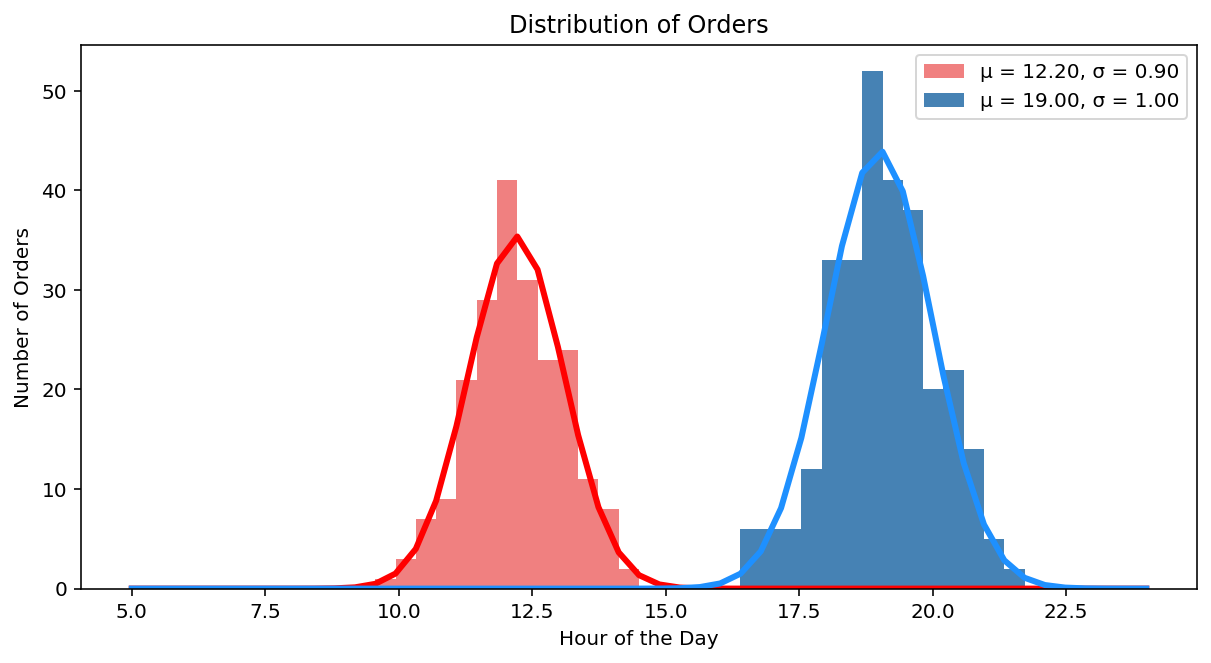

Successfully created the file notebook_v7_titos_tacos_order_events.txt with 500 events
Time to write json: 0.02780914306640625
[
    {
        "correlation_id": "58577662-536f-11ea-81d6-acde48001122",
        "customer": "Titos Tacos",
        "type": "event",
        "version": "1.0.0",
        "source": "telemetry",
        "UTCtimestamp": "2020-02-19 23:27:07.682359+00:00",
        "details": {
            "event_type": "customer_order",
            "customer_id": "5857770c-536f-11ea-81d6-acde48001122",
            "session_id": "58577752-536f-11ea-81d6-acde48001122",
            "hub_id": "585774aa-536f-11ea-81d6-acde48001122",
            "hub_location": null,
            "menu_version": "1.0.0",
            "experiments": null,
            "localtime": "2019-12-31 14:18:36-08:00",
            "UTCtime": "2019-12-31 22:18:36+00:00",
            "details": {
                "order_snapshot": [
                    {
                        "sku": 1,
                        "amount":

In [80]:
plt.figure(figsize=(10,5))
current_directory = os.getcwd()

with open(current_directory + "/" + "parameters.txt") as f: 
    raw = f.read().splitlines()[2:]

parameters = []
for p in raw: 
    nth_params = list(map(float, p.split(",")))
    nth_params[0] = int(nth_params[0])
    parameters.append(nth_params)
    
interval = (5, 24) # 6am to 11pm 
num_of_bins = 50
dx = (interval[1] - interval[0]) / num_of_bins # interval length / number of bins = bin_width


generate_time_start = time.time()
events, order_samples = generate_orders_by_hour(parameters)
generate_time_taken = time.time() - generate_time_start 

print("Time to generate", len(events), "events:", round(generate_time_taken, 3), "seconds")
colors = [["black", "wheat"], 
          ["slateblue", "indigo"], 
          ["steelblue", "dodgerblue"], 
          ["lightcoral", "red"]]

for samples, p in zip(order_samples, parameters): 
    number_of_orders = p[0]
    mu = p[1]
    sigma = p[2]
    amplitude = number_of_orders * dx # number of orders * width of a bin. used to scale 
    if colors != []:
        color = colors.pop()
    else: 
        color = ("darkorange", "yellowgreen")
    count, bins, ignored = plt.hist(samples, bins=num_of_bins, 
                                    range=interval, color = color[0], 
                                    label = "\u03BC = {:.2f}, \u03C3 = {:.2f}".format(mu, sigma))
    pdf = stats.norm.pdf(bins, mu, sigma)
    plt.plot(bins,amplitude*pdf, linewidth=3, color=color[1])

plt.title("Distribution of Orders")
plt.ylabel("Number of Orders")
plt.xlabel("Hour of the Day")
plt.legend()
plt.show()

write_data_start = time.time()
save_directory = os.getcwd()
filename = "notebook_v7_titos_tacos_order_events.txt"
write_to_file(events, filename)
with open(save_directory + "/" + filename) as file:
    data = json.load(file)

write_data_end = time.time()
write_time_taken = write_data_end - write_data_start 
print("Time to write json:", write_time_taken)

print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 

I can generate events for a given number of orders by distribution. I made a lot of assumptions about the events generated. For example, each event is always a unique customer, each event only has one type of event type, namely "customer_order", there are no repeat customers, every event is a unique session and has at most one event. 

I want to do away with some of those assumptions (or at least capture them in a distribution). I'll do this by first generating synthetic customers that generate synthetic events. 